<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module00_02_GPU_and_Matrix_Multiplications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Why GPUs?**

  * GPUs = "graphics processing units"
  * Because modern machine learning involves a lot of matrix operations

**Historical accident**

  * GPU chips are optimized for exactly this type of matrix multiplication
  * If you can transform a 3D vector, you can transform a 300D vector

In [3]:
import matplotlib.pyplot as plt

In [7]:
import torch
import time
import numpy as np

In [4]:
torch.cuda.is_available()

True

In [8]:
ntimes = 1

results = []
for n in range(2000, 10000, 1000):

    print(f'\n------------ n is {n}')

    # compare to operations at the end of notebook 01
    a = np.random.uniform(size=(n, n)).astype(np.float32)
    b = np.random.uniform(size=(n, n)).astype(np.float32)
    print('np type', a.dtype)

    at = torch.from_numpy(a)
    bt = torch.from_numpy(b)
    print('torch type', at.dtype)

    atgpu = at.to('cuda')
    btgpu = bt.to('cuda')
    print('cuda type', atgpu.dtype)


    # @ = matrix multiplcation "matmul" operator
    # AB = C -> c_ij = sum(a_ik*b_kj) for k in [1..n], i in [1..# rows in A], j in [1..# cols in B]
    # (n is the magnitude of the other dimension in each matric)
    # therefore AB is defined iff number of columns in A == number of rows in B

    start_time = time.time()
    for i in range(ntimes):
        c = a @ b
    nptime = time.time() - start_time
    print(f'Numpy took {nptime:.5f} seconds. {c[0, 0:5]}')


    start_time = time.time()
    for i in range(ntimes):
        ct = at @ bt
    torchtime = time.time() - start_time
    print(f'Pytorch took {torchtime:.5f} seconds. {ct[0, 0:5]}')


    start_time = time.time()
    for i in range(ntimes):
        ctgpu = atgpu @ btgpu
    torch.cuda.synchronize()
    cudatime = time.time() - start_time
    print(f'Pytorch cuda took {cudatime:.5f} seconds. {ctgpu[0, 0:5]}')
    print(f'Cuda is {nptime / cudatime :.5f} times faster.')

    results.append([n, nptime, torchtime, cudatime])




------------ n is 2000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 0.21242 seconds. [502.5482  487.52136 498.57666 495.60812 500.10144]
Pytorch took 0.30741 seconds. tensor([502.5482, 487.5213, 498.5767, 495.6081, 500.1014])
Pytorch cuda took 0.11606 seconds. tensor([502.5483, 487.5216, 498.5768, 495.6079, 500.1013], device='cuda:0')
Cuda is 1.83028 times faster.

------------ n is 3000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 0.79694 seconds. [749.351   738.1343  745.7226  749.35925 772.31305]
Pytorch took 1.11804 seconds. tensor([749.3511, 738.1343, 745.7226, 749.3591, 772.3130])
Pytorch cuda took 0.01995 seconds. tensor([749.3514, 738.1344, 745.7228, 749.3588, 772.3129], device='cuda:0')
Cuda is 39.93689 times faster.

------------ n is 4000
np type float32
torch type torch.float32
cuda type torch.float32
Numpy took 3.26142 seconds. [1005.8423   983.5676  1012.2505  1023.1042  1000.14703]
Pytorch took 3.33302 second

In [10]:
results[-1] # results is currently a list, can't do this operation on lists

[9000, 21.518542528152466, 19.928617000579834, 0.40815234184265137]

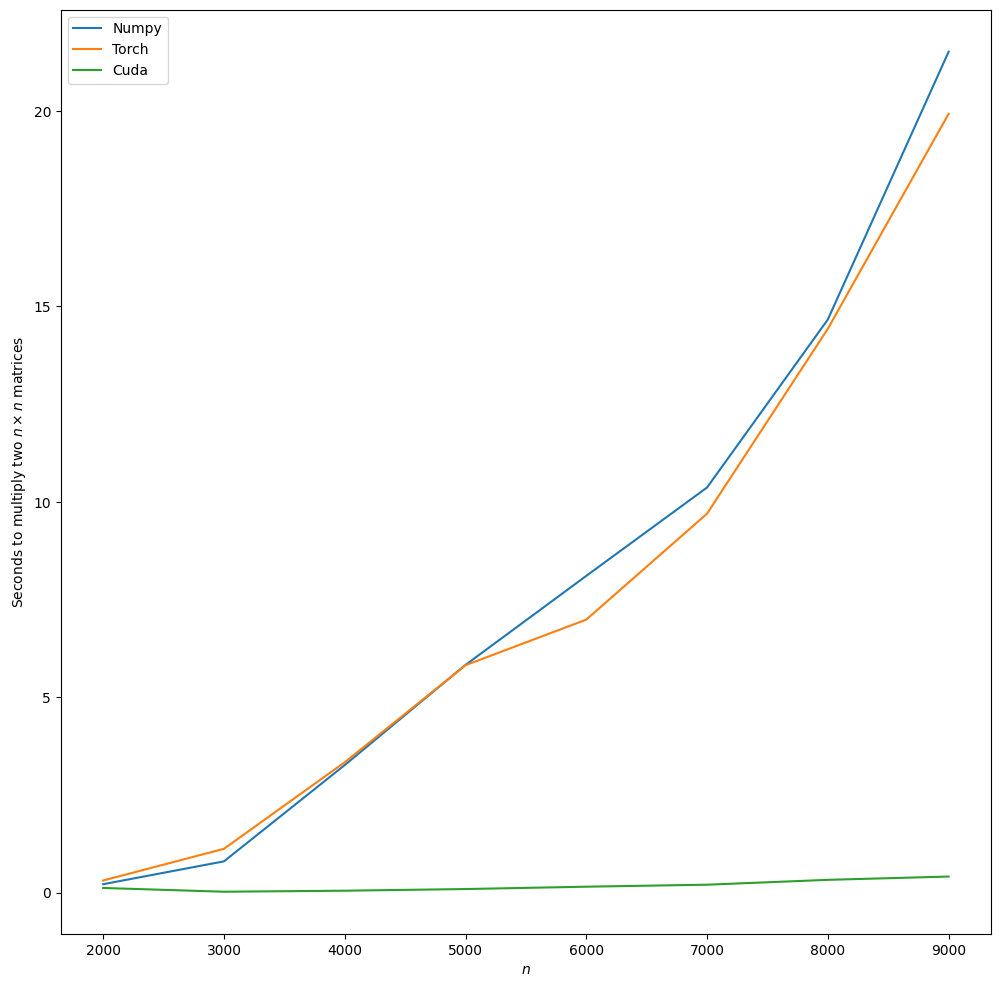

In [11]:
results = np.array(results)

plt.figure(figsize=(12, 12))
plt.plot(results[:, 0], results[:, 1:])
plt.legend(('Numpy', 'Torch', 'Cuda'))
plt.xlabel('$n$')
plt.ylabel(r'Seconds to multiply two $n \times n$ matrices');

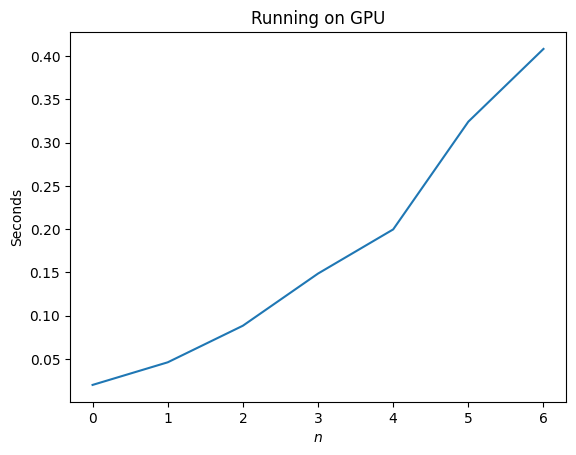

In [12]:
plt.plot(results[1:, -1])
plt.xlabel('$n$')
plt.ylabel('Seconds')
plt.title('Running on GPU');